# Paris Saclay Center for Data Science : prédiction du nombre de passagers aériens

## Introduction
L'ensemble de données nous a été donné par une société anonyme qui s'occupe de la réservation des billets d'avion. Les données sont "maigres", mais elles contiennent : 

- la date de départ
- l'aéroport de départ
- l'aéroport d'arrivée
- la moyenne et l'écart-type du nombre de semaines des réservations effectuées avant la date de départ
- un champ appelé `log_PAX` qui est lié au nombre de passagers (le nombre réel a été modifié pour des raisons de confidentialité)

L'objectif est de prédire la colonne `log_PAX`. La qualité de la prédiction est mesurée par RMSE.

Les données sont évidemment limitées, mais comme les données et les informations de localisation sont disponibles, elles peuvent être jointes à des données externes. Le défi de ce RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien.

In [2]:
import os
from distance_calcul import distance
from scipy.stats import mode
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from describe import stats_histo
import problem
import warnings
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## Chargement des données

Les données relatives à la formation et aux tests se trouvent dans le dossier `data`. Elles sont compressées dans un fichier `csv` (c'est-à-dire `csv.bz2`). Nous pouvons charger l'ensemble de données en utilisant des pandas.

In [3]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [4]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


La colonne `log_PAX` est la cible de notre problème de régression. Les autres colonnes sont les caractéristiques qui seront utilisées pour la prédiction.

`Departure` et `Arrival` sont le code de l'aéroport. Toutefois, nous voyons que la `DateOfDeparture` devrait être une date au lieu d'une chaîne de caractères. Nous pouvons utiliser des pandas pour convertir ces données.

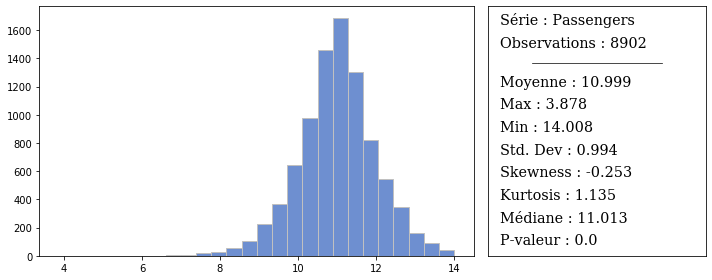

In [4]:
stats_histo(y_train, 'Passengers')

## Préprocessing

Nous effectuerons toutes les étapes de prétraitement dans le cadre d'une `pipeline` scikit-learn qui enchaîne les étapes de transformation et d'estimation. 

Cette méthode est pratique et sûre (elle permet d'éviter les fuites de statistiques de vos données de test dans le modèle formé lors de la validation croisée). De plus, l'ensemble du pipeline peut être évalué avec `cross_val_score`.

Pour effectuer le codage ci-dessus dans un pipeline scikit-learn, nous allons créer une fonction et utiliser `FunctionTransformer` pour la rendre compatible avec l'API scikit-learn.

### Transformeurs : préprocessing des dates

La mise en colonnes numériques des dates est une opération courante lorsque les données des séries chronologiques sont analysées à l'aide de prédicteurs non paramétriques. Le code ci-dessous permet d'effectuer les transformations suivantes :

- colonnes numériques pour l'année (2011-2012) 
- le mois (1-12) 
- le jour du mois (1-31),
- le jour de la semaine (0-6) 
- la semaine de l'année (1-52)

In [32]:
def parse_date(x):
    date = pd.to_datetime(x, format="%Y-%m-%d")
    return pd.Series([date.year, date.month, date.day, date.weekday(), date.week])

In [33]:
from sklearn.preprocessing import FunctionTransformer

def _encoder_dates(X):
    X[["year","month","day","weekday","week"]] = X[
    "DateOfDeparture"].apply(parse_date)
    return X.drop(columns=["DateOfDeparture",'day'])

date_encoder = FunctionTransformer(_encoder_dates)

In [190]:
date_encoder.fit_transform(X_train).head()

,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week
0,ORD,DFW,12.875000,9.812647,2012,6,1,25
1,LAS,DEN,14.285714,9.466734,2012,9,0,37
2,DEN,LAX,10.863636,9.035883,2012,10,4,40
3,ATL,ORD,11.480000,7.990202,2011,10,6,40
4,DEN,SFO,11.450000,9.517159,2012,2,1,8


### Transformeur calcul des distances

In [34]:
def compute_dist(X):
    
    dict_lat = {'DFW': 32.89595,'DEN': 39.85841,'LAX': 33.94254,'ORD': 41.9796,
                'SFO': 37.619,'MCO': 28.428890000000003,'LAS': 36.08036,
                'CLT': 35.214009999999995,'MSP': 44.88055,'EWR': 40.6925,
                'PHX': 33.43417,'DTW': 42.21206,'MIA': 25.79325,'BOS': 42.36435,
                'PHL': 39.87195,'JFK': 40.63975,'ATL': 33.640440000000005,
                'LGA': 40.77724,'SEA': 47.44898,'IAH': 29.98047}
    
    dict_long = {'DFW': -97.0372, 'DEN': -104.667, 'LAX': -118.40807, 
                 'ORD': -87.90446, 'SFO': -122.37483999999999, 'MCO': -81.31603, 
                 'LAS': -115.15233, 'CLT': -80.94313000000001, 'MSP': -93.21692, 
                 'EWR': -74.16866, 'PHX': -112.00806000000001, 'DTW': -83.34884, 
                 'MIA': -80.29056, 'BOS': -71.00518000000001, 'PHL': -75.24114, 
                 'JFK': -73.77893, 'ATL': -84.42694, 'LGA': -73.87261, 
                 'SEA': -122.30931000000001, 'IAH': -95.33972}
    
    
    X["Distance"] = X.apply(lambda x : distance((dict_lat[x["Departure"]],dict_long[x["Departure"]]),
              (dict_lat[x["Arrival"]], dict_long[x["Arrival"]])), axis=1)
    
    return X

dist_ = FunctionTransformer(compute_dist)

In [9]:
dist_.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,Distance
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,19,1,25,1290.779961
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,10,0,37,1009.721628
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,5,4,40,1385.461051
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,9,6,40,976.057905
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,21,1,8,1553.249207


### Transformeur : utiliser les données externes

L'objectif de ce défi de données RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien. Nous utiliserons quelques données météorologiques (enregistrées dans `submissions/starting_kit`) pour fournir un exemple de la manière de fusionner des données externes dans un pipeline scikit-learn.

Nous allons d'abord définir une fonction qui fusionne les données externes à nos données de caractéristiques.

In [35]:
__file__ = os.path.join('submissions', 'starting_kit', 'estimator.py')
filepath = os.path.join(os.path.dirname(__file__), 'external_data.csv')

In [36]:
def _merge_external_data(X):
    __file__ = os.path.join('submissions', 'starting_kit', 'estimator.py')
    filepath = os.path.join(os.path.dirname(__file__), 
                            'external_data.csv')
    
    X["DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    X_weather = pd.read_csv(filepath, parse_dates=["Date"])

    X_weather["Precipitationmm"] = X_weather["Precipitationmm"].replace('T',None)
    X_weather["Precipitationmm"] = X_weather["Precipitationmm"].astype(float)
    X_weather["Events"].fillna(mode(X_weather["Events"]).mode[0], inplace=True)
    
    X_weather.drop(columns=["Max Gust SpeedKm/h","Events"], inplace=True)
    
    X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 
                                          'AirPort': 'Arrival'})
    
    X_merged = pd.merge(X, X_weather, 
                        how='left', 
                        on=['DateOfDeparture', 'Arrival'], 
                        sort=False)
    
    return X_merged

data_merger = FunctionTransformer(_merge_external_data)

In [37]:
data_merger.fit_transform(X_train).head(3)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees
0,2012-06-19,ORD,DFW,12.875000,9.812647,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,0.0,5,161
1,2012-09-10,LAS,DEN,14.285714,9.466734,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,16,35,15,0.0,3,207
2,2012-10-05,DEN,LAX,10.863636,9.035883,22,19,16,17,16,14,93,77,61,1018,1016,1014,16,13,8,24,8,0.0,5,266


### Encodage One Hot – Ordinal

In [38]:
def get_dummy(X):
    X = X.join(pd.get_dummies(X["year"],prefix='year'))
    X = X.join(pd.get_dummies(X["month"],prefix='month'))
    #X = X.join(pd.get_dummies(X["day"],prefix='day'))
    X = X.join(pd.get_dummies(X["week"],prefix='week'))
    X = X.join(pd.get_dummies(X["weekday"],prefix='week_day'))
    
    X["Trajet"] = X["Departure"]+ '-' +  X["Arrival"] 
    X = X.join(pd.get_dummies(X["Trajet"],prefix='traj_'))
    
    
    return X.drop(columns=['year','month','week',
                           'weekday',"week","Departure",'Arrival',
                           "Trajet"])

dummy_ = FunctionTransformer(get_dummy)

In [39]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(data_merger, dist_ ,date_encoder, dummy_)

## Feature selection

### Random Forests et feature importances

In [40]:
X = pipeline.fit_transform(X_train)

In [15]:
X.head(2)

,WeeksToDeparture,std_wtd,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Distance,year_2011,year_2012,year_2013,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,traj__ATL-BOS,traj__ATL-CLT,traj__ATL-DEN,traj__ATL-DFW,traj__ATL-DTW,traj__ATL-EWR,traj__ATL-LAX,traj__ATL-LGA,traj__ATL-MCO,traj__ATL-MIA,traj__ATL-MSP,traj__ATL-ORD,traj__ATL-PHL,traj__ATL-SFO,traj__BOS-ATL,traj__BOS-EWR,traj__BOS-LAX,traj__BOS-LGA,traj__BOS-ORD,traj__BOS-PHL,traj__BOS-SFO,traj__CLT-ATL,traj__CLT-LGA,traj__DEN-ATL,traj__DEN-DFW,traj__DEN-LAS,traj__DEN-LAX,traj__DEN-MSP,traj__DEN-ORD,traj__DEN-PHX,traj__DEN-SEA,traj__DEN-SFO,traj__DFW-ATL,traj__DFW-BOS,traj__DFW-DEN,traj__DFW-LAS,traj__DFW-LAX,traj__DFW-LGA,traj__DFW-ORD,traj__DFW-PHL,traj__DFW-SFO,traj__DTW-ATL,traj__DTW-LGA,traj__DTW-ORD,traj__EWR-ATL,traj__EWR-BOS,traj__EWR-LAX,traj__EWR-MCO,traj__EWR-ORD,traj__EWR-SFO,traj__IAH-LAX,traj__IAH-ORD,traj__JFK-LAS,traj__JFK-LAX,traj__JFK-MCO,traj__JFK-MIA,traj__JFK-SFO,traj__LAS-DEN,traj__LAS-DFW,traj__LAS-JFK,traj__LAS-LAX,traj__LAS-ORD,traj__LAS-SFO,traj__LAX-ATL,traj__LAX-BOS,traj__LAX-DEN,traj__LAX-DFW,traj__LAX-EWR,traj__LAX-IAH,traj__LAX-JFK,traj__LAX-LAS,traj__LAX-ORD,traj__LAX-SEA,traj__LAX-SFO,traj__LGA-ATL,traj__LGA-BOS,traj__LGA-CLT,traj__LGA-DFW,traj__LGA-DTW,traj__LGA-MIA,traj__LGA-ORD,traj__MCO-ATL,traj__MCO-EWR,traj__MCO-PHL,traj__MIA-ATL,traj__MIA-JFK,traj__MIA-LGA,traj__MSP-ATL,traj__MSP-DEN,traj__MSP-ORD,traj__ORD-ATL,traj__ORD-BOS,traj__ORD-DEN,traj__ORD-DFW,traj__ORD-DTW,traj__ORD-EWR,traj__ORD-IAH,traj__ORD-LAS,traj__ORD-LAX,traj__ORD-LGA,traj__ORD-MSP,traj__ORD-PHL,traj__ORD-PHX,traj__ORD-SEA,traj__ORD-SFO,traj__PHL-ATL,traj__PHL-BOS,traj__PHL-DFW,traj__PHL-MCO,traj__PHL-ORD,traj__PHX-DEN,traj__PHX-ORD,traj__SEA-DEN,traj__SEA-LAX,traj__SEA-ORD,traj__SEA-SFO,traj__SFO-ATL,traj__SFO-BOS,traj__SFO-DEN,traj__SFO-DFW,traj__SFO-EWR,traj__SFO-JFK,traj__SFO-LAS,traj__SFO-LAX,traj__SFO-ORD,traj__SFO-SEA
0,12.875000,9.812647,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,0.0,5,Rain,161,1290.779961,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,16,35,15,0.0,3,Rain,207,1009.721628,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


On divise notre jeu de données de train en deux split : 

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_train, test_size=0.2, random_state=0)

On peut commencer par un premier modèle d'abre : 

In [41]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 100
max_depth = None
max_features = 10

reg = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    max_features=max_features)

scores = cross_val_score(reg, X, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6111 +/- 0.0244


On récupère les features importance de notre modèle d'abre et leurs nom à partir du dataset original.

In [251]:
feature_importance = reg.fit(X_train,y_train).feature_importances_

In [252]:
feature_names = np.array(list(X_train.columns))

On affiche le diagramme en barre des importances : 

In [253]:
idx = feature_importance.argsort()[::-1][:40]
importances_ord = feature_importance[idx]
feature_names_ord = np.array(feature_names)[idx]

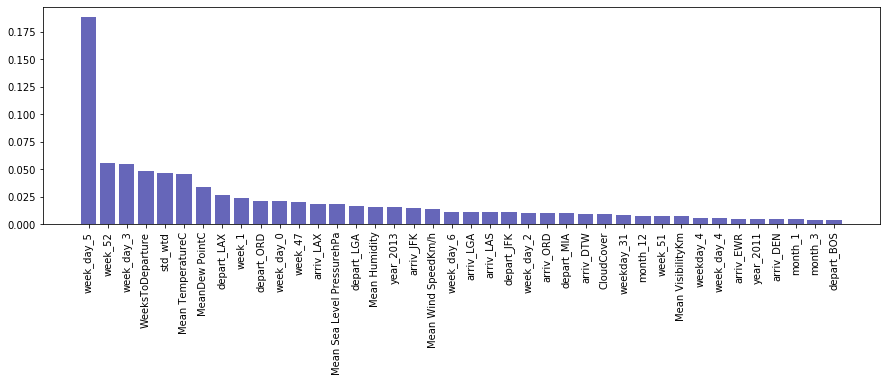

In [254]:
plt.figure(figsize=(15,4))

plt.bar(feature_names_ord, importances_ord, 
         color = 'darkblue', alpha= 0.6);
plt.xticks(rotation=90);

### SelectFromModel : Lasso

In [42]:
feature_names = np.array(list(X.columns))

In [43]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# avec 0.001 j'ai eu un bon score
select = SelectFromModel(Lasso(0.001, random_state=1))
select.fit_transform(X,y_train)
selected_features = feature_names[select.get_support()]

In [44]:
X_train_select = X[selected_features]
X_test_select = X[selected_features]

In [45]:
X_train_select.head()

,WeeksToDeparture,std_wtd,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Distance,year_2011,year_2013,month_4,month_5,month_6,month_7,month_8,month_9,month_12,week_1,week_2,week_4,week_5,week_6,week_8,week_9,week_10,week_12,week_14,week_16,week_17,week_18,week_19,week_20,week_22,week_27,week_29,week_34,week_35,week_36,week_37,week_38,week_41,week_42,week_44,week_47,week_49,week_50,week_51,week_52,week_day_0,week_day_1,week_day_2,week_day_3,week_day_5,week_day_6,traj__ATL-BOS,traj__ATL-CLT,traj__ATL-DFW,traj__ATL-DTW,traj__ATL-LAX,traj__ATL-LGA,traj__ATL-MCO,traj__ATL-MIA,traj__ATL-MSP,traj__ATL-ORD,traj__ATL-PHL,traj__BOS-ATL,traj__BOS-EWR,traj__BOS-LGA,traj__BOS-ORD,traj__BOS-PHL,traj__BOS-SFO,traj__CLT-ATL,traj__DEN-ATL,traj__DEN-DFW,traj__DEN-LAS,traj__DEN-MSP,traj__DEN-ORD,traj__DEN-SEA,traj__DFW-ATL,traj__DFW-BOS,traj__DFW-DEN,traj__DFW-LAS,traj__DFW-LAX,traj__DFW-LGA,traj__DFW-ORD,traj__DFW-PHL,traj__DTW-ATL,traj__DTW-LGA,traj__DTW-ORD,traj__EWR-BOS,traj__EWR-LAX,traj__EWR-MCO,traj__EWR-ORD,traj__IAH-LAX,traj__JFK-LAX,traj__JFK-MCO,traj__JFK-MIA,traj__JFK-SFO,traj__LAS-DEN,traj__LAS-DFW,traj__LAS-LAX,traj__LAS-ORD,traj__LAS-SFO,traj__LAX-ATL,traj__LAX-DEN,traj__LAX-DFW,traj__LAX-IAH,traj__LAX-JFK,traj__LAX-LAS,traj__LAX-ORD,traj__LAX-SFO,traj__LGA-ATL,traj__LGA-BOS,traj__LGA-DFW,traj__LGA-DTW,traj__LGA-ORD,traj__MCO-ATL,traj__MCO-EWR,traj__MCO-PHL,traj__MIA-ATL,traj__MIA-JFK,traj__MSP-ATL,traj__MSP-DEN,traj__MSP-ORD,traj__ORD-ATL,traj__ORD-BOS,traj__ORD-DFW,traj__ORD-EWR,traj__ORD-IAH,traj__ORD-LAX,traj__ORD-LGA,traj__ORD-MSP,traj__ORD-PHL,traj__ORD-PHX,traj__ORD-SEA,traj__ORD-SFO,traj__PHL-ATL,traj__PHL-DFW,traj__PHL-MCO,traj__PHL-ORD,traj__PHX-ORD,traj__SEA-DEN,traj__SEA-ORD,traj__SEA-SFO,traj__SFO-ATL,traj__SFO-BOS,traj__SFO-JFK,traj__SFO-LAS,traj__SFO-LAX,traj__SFO-ORD,traj__SFO-SEA
0,12.875000,9.812647,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,48,29,0.0,5,161,1290.779961,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,35,15,0.0,3,207,1009.721628,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,22,19,16,17,16,14,93,77,61,1018,1016,1014,13,8,24,8,0.0,5,266,1385.461051,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,27,19,11,12,10,9,83,58,33,1028,1026,1024,16,16,23,6,0.0,1,93,976.057905,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,9.517159,16,12,8,10,8,7,93,79,64,1027,1025,1024,12,3,24,8,0.0,7,300,1553.249207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [46]:
selected_features

array(['WeeksToDeparture', 'std_wtd', 'Max TemperatureC',
       'Mean TemperatureC', 'Min TemperatureC', 'Dew PointC',
       'MeanDew PointC', 'Min DewpointC', 'Max Humidity', 'Mean Humidity',
       'Min Humidity', 'Max Sea Level PressurehPa',
       'Mean Sea Level PressurehPa', 'Min Sea Level PressurehPa',
       'Mean VisibilityKm', 'Min VisibilitykM', 'Max Wind SpeedKm/h',
       'Mean Wind SpeedKm/h', 'Precipitationmm', 'CloudCover',
       'WindDirDegrees', 'Distance', 'year_2011', 'year_2013', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_12',
       'week_1', 'week_2', 'week_4', 'week_5', 'week_6', 'week_8',
       'week_9', 'week_10', 'week_12', 'week_14', 'week_16', 'week_17',
       'week_18', 'week_19', 'week_20', 'week_22', 'week_27', 'week_29',
       'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_41',
       'week_42', 'week_44', 'week_47', 'week_49', 'week_50', 'week_51',
       'week_52', 'week_day_0', 'week_day_1', 'w

### Test de dépendances : recherche des variables en relation avec Log_PAX

#### Variables quantitatives

On sélectionne toutes les variables quantitatives de notre jeu de données : 

In [164]:
from scipy.stats import pearsonr

quanti = X.iloc[:,:21]
quanti.Precipitationmm = quanti.Precipitationmm.replace('T',None)
quanti["Precipitationmm"] = quanti["Precipitationmm"].astype(float)

On applique le test de pearson pour connaître la corrélation avec la variable cible : 

In [173]:
liste_corr = []
liste_pval = []

for i in quanti.columns[:-2] :
    x = quanti[i].fillna(np.mean)
    r, pv = pearsonr(x,y_train)
    liste_corr.append(r)
    liste_pval.append(pv)

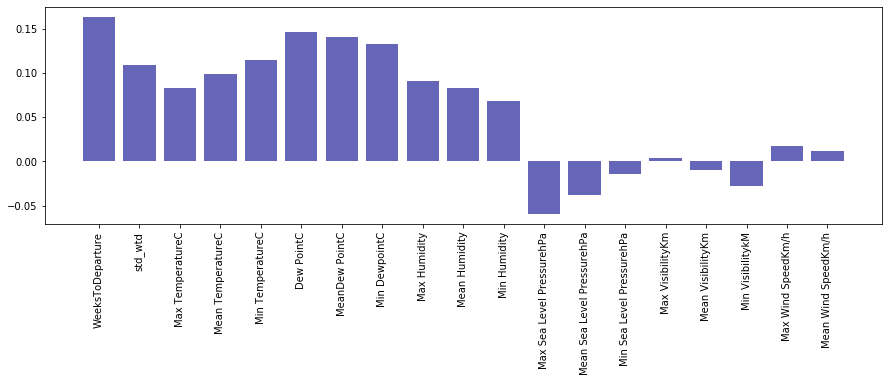

In [157]:
plt.figure(figsize=(15,4))
plt.bar(quanti.columns[:-2], liste_corr, 
         color = 'darkblue', alpha= 0.6);
plt.xticks(rotation=90);

A partir de ces informations on peut garder : 

- 'Min TemperatureC', 'Dew PointC', 'Max Humidity','Max Sea Level PressurehPa',

#### Variable qualitatives

In [123]:
from scipy.stats import f_oneway

Event = pd.concat([pd.Series(y_train), 
                   X.iloc[:,22].fillna(mode(X.iloc[:,22]).mode[0])], axis=1)


In [144]:
test_date = date_encoder.fit_transform(X_train).iloc[:,-5:]

In [187]:
test_aero = date_encoder.fit_transform(X_train).iloc[:,:2]

In [146]:
def test_quali(X, columns):
    X = pd.concat([pd.Series(y_train), X], axis=1)

    liste_event = []
    for i in np.unique(X[columns]):
        liste_event.append(X.iloc[:,0][X[columns] == i])
    
    return f_oneway(*liste_event)

In [367]:
test_quali(Event,'Events')

F_onewayResult(statistic=5.57400501730104, pvalue=3.1337816066182383e-10)

In [152]:
for i in test_date.columns :
    print(i)
    print(test_quali(test_date,i))

year
F_onewayResult(statistic=51.05882501948979, pvalue=8.947415893900378e-23)
month
F_onewayResult(statistic=31.609429725617435, pvalue=1.720739386101811e-66)
day
F_onewayResult(statistic=6.527410915556118, pvalue=6.533811760988845e-26)
weekday
F_onewayResult(statistic=402.9947592509257, pvalue=0.0)
week
F_onewayResult(statistic=20.565292231400864, pvalue=5.855413922941591e-175)


In [188]:
for i in test_aero.columns : 
    print(i)
    print(test_quali(test_aero,i))

Departure
F_onewayResult(statistic=37.45422773032868, pvalue=4.8820940332944604e-133)
Arrival
F_onewayResult(statistic=41.17566713845023, pvalue=7.036677887364624e-147)


On peut retirer : 'day'

## Recherche de modèles

### Niveau 1 : RandomForest et ExtraTree

In [47]:
mydata = pipeline.fit_transform(X_train)

In [289]:
mydata.head(1)

,WeeksToDeparture,std_wtd,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Distance,year_2011,year_2012,year_2013,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,depart_ATL,depart_BOS,depart_CLT,depart_DEN,depart_DFW,depart_DTW,depart_EWR,depart_IAH,depart_JFK,depart_LAS,depart_LAX,depart_LGA,depart_MCO,depart_MIA,depart_MSP,depart_ORD,depart_PHL,depart_PHX,depart_SEA,depart_SFO,arriv_ATL,arriv_BOS,arriv_CLT,arriv_DEN,arriv_DFW,arriv_DTW,arriv_EWR,arriv_IAH,arriv_JFK,arriv_LAS,arriv_LAX,arriv_LGA,arriv_MCO,arriv_MIA,arriv_MSP,arriv_ORD,arriv_PHL,arriv_PHX,arriv_SEA,arriv_SFO,events_Fog,events_Fog-Rain,events_Fog-Rain-Hail-Thunderstorm,events_Fog-Rain-Snow,events_Fog-Rain-Snow-Thunderstorm,events_Fog-Rain-Thunderstorm,events_Fog-Snow,events_Rain,events_Rain-Hail-Thunderstorm,events_Rain-Snow,events_Rain-Snow-Thunderstorm,events_Rain-Thunderstorm,events_Snow,events_Thunderstorm
0,12.875,9.812647,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,0.0,5,161,1290.779961,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [48]:
select_by_corr = mydata[selected_features]

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

reg = RandomForestRegressor(n_estimators=100, random_state=2)

scores = cross_val_score(reg, select_by_corr, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4561 +/- 0.0277


In [50]:
from sklearn.ensemble import ExtraTreesRegressor

boost = ExtraTreesRegressor(random_state=1)

scores = cross_val_score(boost, select_by_corr, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4365 +/- 0.0172


On peut regarder l'ExtraTree sur le jeu de données de test : 

In [51]:
from sklearn.metrics import mean_squared_error

X_test_select = pipeline.fit_transform(X_test)
X_test_select = X_test_select[selected_features]

prediction = boost.fit(select_by_corr, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

RMSE: 0.4474


### Niveau 2 : Stacking des modèles

On peut utiliser une méthode d'ensemble pour stacker les modèles de régressions : 

In [54]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor

estimators = [('ridge', RidgeCV()),
               ('lasso', LassoCV(random_state=42)),
               ('gradboost', GradientBoostingRegressor()),
             ("random_forest",RandomForestRegressor())]

stack = StackingRegressor(estimators=estimators, 
                          final_estimator=ExtraTreesRegressor())

stack.fit(X_train_select,y_train);

In [56]:
scores = cross_val_score(stack, select_by_corr, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4421 +/- 0.0274


Sur l'échantillon de Test : 

In [57]:
pred = stack.predict(X_test_select)

In [58]:
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,pred))))

RMSE: 0.4549


### Niveau 3 : XGBoost

In [60]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators= 500)

scores = cross_val_score(xgb, select_by_corr, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4172 +/- 0.0200


In [61]:

prediction = xgb.fit(select_by_corr, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

RMSE: 0.4313


### Niveau 4 : LightGBM

In [ ]:
from lightgbm import LGBMRegressor


lgbm = LGBMRegressor()


scores = cross_val_score(lgbm, select_by_corr, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))